In [1]:
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from scipy.stats import pearsonr

# Load Data

In [2]:
# test
order = pickle.load(open('C:/Users/Vanda/PycharmProjects/dense/results/nppmi/order/glove.6B.400k.300d.txt_f_conceptnet56_top50000_base_order.p', 'rb'))
map_c = pickle.load(open('C:/Users/Vanda/PycharmProjects/dense/results/evaluation/cummulated/glove.6B.400k.300d.txt_f_conceptnet56_top50000_map_cummulated.p', 'rb'))

In [3]:
order

[(200, 0.14518691035284803),
 (150, 0.13102181064218377),
 (43, 0.11691997498558164),
 (278, 0.11338081791888052),
 (33, 0.11206934465446838),
 (295, 0.10996757321258704),
 (179, 0.10906686403802891),
 (175, 0.10791578400244975),
 (242, 0.10732443125194453),
 (181, 0.10688828749265908),
 (220, 0.10583131988057615),
 (254, 0.1055941589719844),
 (238, 0.10432035229882479),
 (196, 0.10136839088292486),
 (154, 0.09934470841759324),
 (15, 0.09903707187597788),
 (129, 0.0982055309841864),
 (227, 0.09785620565255462),
 (61, 0.09625599202922025),
 (104, 0.09526563129844069),
 (64, 0.09430901322567048),
 (299, 0.09424427760221576),
 (279, 0.09413514049269224),
 (66, 0.09381902073587865),
 (173, 0.093532531998934),
 (184, 0.093215859063237),
 (239, 0.09305039713199188),
 (206, 0.09287031455280685),
 (199, 0.09253341150338414),
 (213, 0.09246950236654529),
 (193, 0.09246477005297667),
 (285, 0.09219534516720822),
 (169, 0.09193674776192513),
 (143, 0.09186541131511354),
 (211, 0.09182650794901957

In [4]:
class EvalData(object):
    def __init__(self, order, mp_c, map_c, mrr_c, tsa_base_c, tsa_concept_c, name):
        self.order = order
        self.mp = mp_c
        self.map = map_c
        self.mrr = mrr_c
        self.tsa_base = tsa_base_c
        self.tsa_concept = tsa_concept_c
        self.name = name

In [5]:
def load_data(embedding_name, dense=False):
    if dense:
        folder = "dense"
    else:
        folder = "all"
    order_dir = 'C:/Users/Vanda/PycharmProjects/' + folder + '/results/nppmi/order/'
    cummulated_dir = 'C:/Users/Vanda/PycharmProjects/' + folder + '/results/evaluation/cummulated/'
    
    order = pickle.load(open(order_dir + embedding_name + '_base_order.p', 'rb'))
    mp_c = pickle.load(open(cummulated_dir + embedding_name + '_mp_cummulated.p', 'rb'))
    map_c = pickle.load(open(cummulated_dir + embedding_name + '_map_cummulated.p', 'rb'))
    mrr_c = pickle.load(open(cummulated_dir + embedding_name + '_mrr_r_cummulated.p', 'rb'))
    tsa_base_c = pickle.load(open(cummulated_dir + embedding_name + '_tsa_base_k_acc_cummulated.p', 'rb'))
    tsa_concept_c = pickle.load(open(cummulated_dir + embedding_name + '_tsa_concept_k_acc_cummulated.p', 'rb'))
    cd = EvalData(order, mp_c, map_c, mrr_c, tsa_base_c, tsa_concept_c, embedding_name)
    return cd

In [6]:
dl_400000_cNet = load_data('glove300d_l_0.5_DL_top400000.emb.gz_f_conceptnet56_top50000')
gs_400000_cNet = load_data('glove300d_l_0.5_GS_top400000.emb.gz_f_conceptnet56_top50000')
kmeans_400000_cNet = load_data('glove300d_l_0.5_kmeans_top400000.emb.gz_f_conceptnet56_top50000')
dense = load_data('glove.6B.400k.300d.txt_f_conceptnet56_top50000', True)

# Cummulate Data

In [7]:
class CummulatedData(object):
    def __init__(self, data, point):
        self.data = data
        self.point = point

In [8]:
def cummulate(ev_metric_c, order):
    ev_cummulated = []
    found = False
    point = len(order)
    for i in range(len(ev_metric_c)):
        size = i
        base_id = order[i][0]
        ppmi_val = order[i][1]
        
        if size == 0:
            ev_cummulated.append(ev_metric_c[base_id])
        else:
            prev = ev_cummulated[size-1]
            ev_cummulated.append(prev+ev_metric_c[base_id])
            
        if not found and ppmi_val <= 0:
            found = True
            point = i
    if point != len(ev_metric_c)-1:
        point = point-1
    for i in range(len(ev_cummulated)):
        size = i+1
        ev_cummulated[i] = ev_cummulated[i]/size
    return CummulatedData(ev_cummulated, point)

In [9]:
def cummulate2(ev_metric_c, order):
    ev_cummulated1 = []
    ev_cummulated2 = []
    found = False
    point = len(ev_metric_c)-1
    for i in range(len(ev_metric_c)):
        size = i
        base_id = order[i][0]
        ppmi_val = order[i][1]
        values = ev_metric_c[base_id]
        if size == 0:
            ev_cummulated1.append(values[0])
            ev_cummulated2.append(values[1])
        else:
            prev1 = ev_cummulated1[size-1]
            prev2 = ev_cummulated2[size-1]
            ev_cummulated1.append(prev1+values[0])
            ev_cummulated2.append(prev2+values[1])
        if not found and ppmi_val <= 0:
            found = True
            point = i
    if point != len(ev_metric_c)-1:
        point = point-1
    for i in range(len(ev_cummulated1)):
        size = i+1
        ev_cummulated1[i] = ev_cummulated1[i]/size
        ev_cummulated2[i] = ev_cummulated2[i]/size
    return CummulatedData(ev_cummulated1, point), CummulatedData(ev_cummulated2, point)

In [10]:
def cummulate_concepts(ev_metric):
    ev_1 = sorted([v1 for v1, v2 in ev_metric], reverse=True)
    ev_2 = sorted([v2 for v1, v2 in ev_metric], reverse=True)
    ev_cummulated1 = []
    ev_cummulated2 = []
    point = -1
    for i in range(len(ev_1)):
        size = i
        if size == 0:
            ev_cummulated1.append(ev_1[i])
            ev_cummulated2.append(ev_2[i])
        else:
            prev1 = ev_cummulated1[size-1]
            prev2 = ev_cummulated2[size-1]
            ev_cummulated1.append(prev1+ev_1[i])
            ev_cummulated2.append(prev2+ev_2[i])

    for i in range(len(ev_cummulated1)):
        size = i+1
        ev_cummulated1[i] = ev_cummulated1[i]/size
        ev_cummulated2[i] = ev_cummulated2[i]/size
    return CummulatedData(ev_cummulated1, point), CummulatedData(ev_cummulated2, point)

# Plot Data

In [11]:
def gather_metrics(data):
    mp = cummulate(data.mp, data.order)
    mapp = cummulate(data.map, data.order)
    mrr, mr = cummulate2(data.mrr, data.order)
    tsa_base, tsa_base_k = cummulate2(data.tsa_base, data.order)
    tsa_concept, tsa_concept_k = cummulate_concepts(data.tsa_concept)
    return mp, mapp, mrr, mr, tsa_base, tsa_base_k, tsa_concept, tsa_concept_k

In [36]:
def plot_metric_by_dictionary(metric1, metric2, metric3, metric4, metric_name, title, names):
    markersize = 10
    markeredgewidth = 3
    zero1 = metric1.data[0:metric1.point]
    zero2 = metric2.data[0:metric2.point]
    zero3 = metric3.data[0:metric3.point]
    zero4 = metric4.data[0:metric4.point]
#     print(len(zero1), len(zero2), len(zero3), print(zero4))
    plt.plot(metric1.data, 'r')
    plt.plot(metric3.data, 'g')
    plt.plot(metric2.data, 'b')
    plt.plot(metric4.data, 'c')
    plt.plot(zero1, 'r')
    plt.plot(zero3, 'g')
    plt.plot(zero2, 'b')
    plt.plot(zero4, 'c')
    
    if metric1.point != -1:
        plt.plot(metric1.point, metric1.data[metric1.point], 'rx', ms=markersize, mew=markeredgewidth)
        plt.plot(metric2.point, metric2.data[metric2.point], 'bx', ms=markersize, mew=markeredgewidth)
        plt.plot(metric3.point, metric3.data[metric3.point], 'gx', ms=markersize, mew=markeredgewidth)
        plt.plot(metric4.point, metric4.data[metric4.point], 'cx', ms=markersize, mew=markeredgewidth)
#     plt.ylabel(metric_name, fontsize=20)
    if metric_name.find('concept')!=-1:
        plt.xlabel("#concepts", fontsize=20)
    else: 
        plt.xlabel("#bases", fontsize=20)
    plt.title(title, fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    if metric_name == 'MP' or metric_name == 'TAB' or metric_name == 'TAC':
        plt.legend(names, fontsize=15)
    out_dir = '../../../dense/results/evaluation/cummulated/plots/'
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    out_name = out_dir + metric_name.replace(' ', '_') + title.replace(' ', '_')
    plt.tight_layout()
    plt.savefig((out_name+"_by_dict_0.pdf"))
    plt.show()



In [37]:
def tac_mean_dev(data):
    tac = data.tsa_concept
    tac_1 = [v1 for v1, v2 in tac]
    print('mean: ', np.mean(tac_1))
    print('std dev: ',np.std(tac_1))


In [38]:
tac_mean_dev(dl_400000_cNet)
tac_mean_dev(gs_400000_cNet)
tac_mean_dev(kmeans_400000_cNet)
tac_mean_dev(dense)

mean:  0.49818196418523686
std dev:  0.24084087019670455
mean:  0.4970428219672534
std dev:  0.2281527919087552
mean:  0.4495143789845917
std dev:  0.20188347311135924
mean:  0.7934338734812965
std dev:  0.14342916015417426


In [39]:
def plot_by_dictionary(data1, data2, data3, data4, title = " ", names=['DLSC', 'kmeans', 'GMPO']):
    mp1, mapp1, mrr1, mr1, tsa_base1, tsa_base_k1, tsa_concept1, tsa_concept_k1 = gather_metrics(data1)
    mp2, mapp2, mrr2, mr2, tsa_base2, tsa_base_k2, tsa_concept2, tsa_concept_k2 = gather_metrics(data2)
    mp3, mapp3, mrr3, mr3, tsa_base3, tsa_base_k3, tsa_concept3, tsa_concept_k3 = gather_metrics(data3)
    mp4, mapp4, mrr4, mr4, tsa_base4, tsa_base_k4, tsa_concept4, tsa_concept_k4 = gather_metrics(data4)
    plot_metric_by_dictionary(mp1, mp2, mp3, mp4, "MP", title, names)
    plot_metric_by_dictionary(mapp1, mapp2, mapp3, mapp4, "MAP", title, names)
    plot_metric_by_dictionary(mrr1, mrr2, mrr3, mrr4, "MRR", title, names)
    plot_metric_by_dictionary(tsa_base1, tsa_base2, tsa_base3, tsa_base4, "TAB", title, names)
    plot_metric_by_dictionary(tsa_base_k1, tsa_base_k2, tsa_base_k3, tsa_base_k4, "TAB_k", title,names)
    plot_metric_by_dictionary(tsa_concept1, tsa_concept2, tsa_concept3, tsa_concept4, "TAC", title, names)
    plot_metric_by_dictionary(tsa_concept_k1, tsa_concept_k2, tsa_concept_k3, tsa_concept_k4, "TAC_k", title, names)

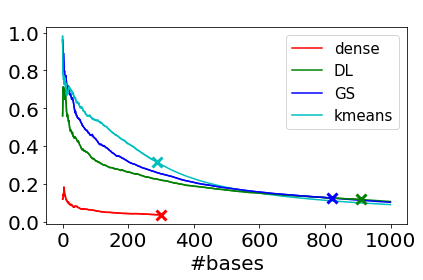

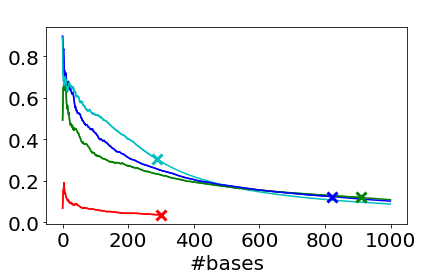

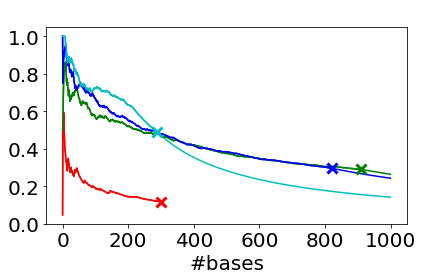

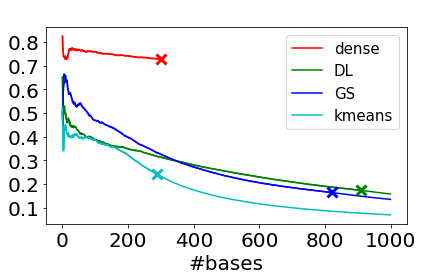

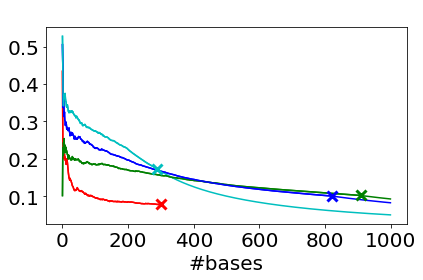

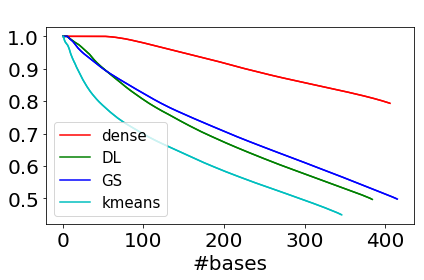

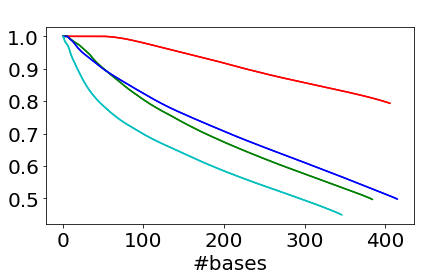

In [40]:
plot_by_dictionary(dense, dl_400000_cNet, gs_400000_cNet, kmeans_400000_cNet, names=['dense', 'DL', 'GS', 'kmeans'])

In [31]:
def plot_reg_coeffs(metric1, metric2, metric_name, title):
    markersize = 10
    plt.plot(metric1.data, 'r')
    plt.plot(metric2.data, 'b')
    print(metric1.point, metric2.point)
    if metric1.point != -1:
        plt.plot(metric1.point, metric1.data[metric1.point-1], 'rx', ms=markersize)
        plt.plot(metric2.point, metric2.data[metric2.point-1], 'bx', ms=markersize)
#     plt.ylabel(metric_name, fontsize=20)
    if metric_name.find('concept')!=-1:
        plt.xlabel("#concepts", fontsize=20)
    else: 
        plt.xlabel("#bases", fontsize=20)
    plt.title(title, fontsize=20)
    plt.legend(['0.1', '0.5'], fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    out_name = metric_name.replace(' ', '_') + '_' + title.replace(' ', '_')
    plt.savefig((out_name+"_reg_coeffs.pdf"))
    plt.show()

In [32]:
def compare_reg_coeffs(data1, data2, title):
    mp1, mapp1, mrr1, mr1, tsa_base1, tsa_base_k1, tsa_concept1, tsa_concept_k1 = gather_metrics(data1)
    mp2, mapp2, mrr2, mr2, tsa_base2, tsa_base_k2, tsa_concept2, tsa_concept_k2 = gather_metrics(data2)
    plot_reg_coeffs(mp1, mp2, 'MP', ('Regularization coefficients, ' +  title))
    plot_reg_coeffs(mapp1, mapp2, 'MAP', ('Regularization coefficients, ' +  title))
    plot_reg_coeffs(mrr1, mrr2, 'MRR', ('Regularization coefficients, ' +  title))
    plot_reg_coeffs(tsa_base1, tsa_base2, 'TAB', ('Regularization coefficients, ' +  title))
    plot_reg_coeffs(tsa_concept1, tsa_concept2, 'TAC', ('Regularization coefficients, ' +  title))

999 821


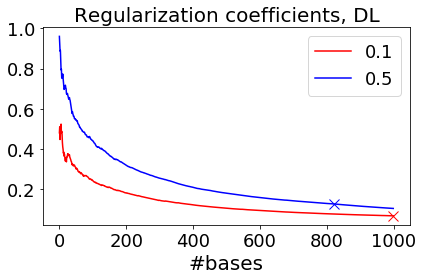

999 821


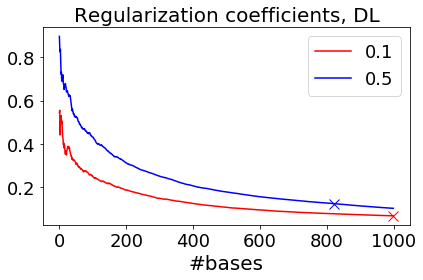

999 821


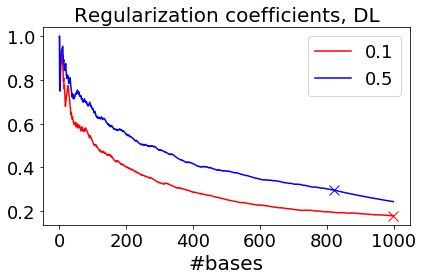

999 821


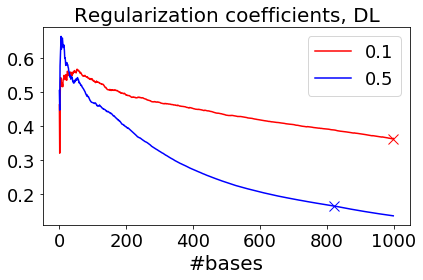

-1 -1


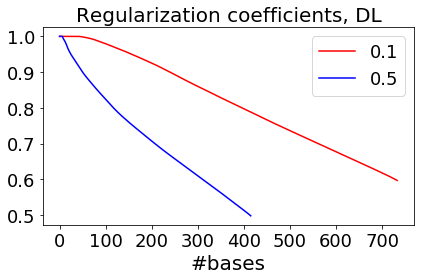

963 908


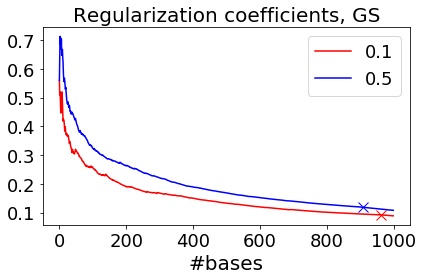

963 908


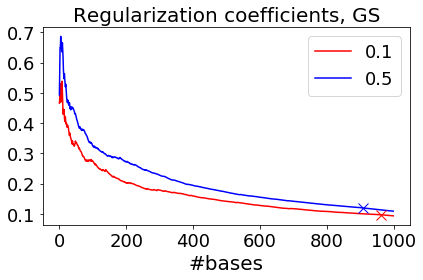

963 908


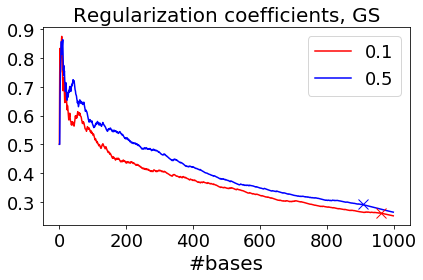

963 908


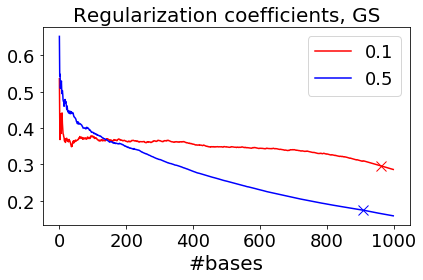

-1 -1


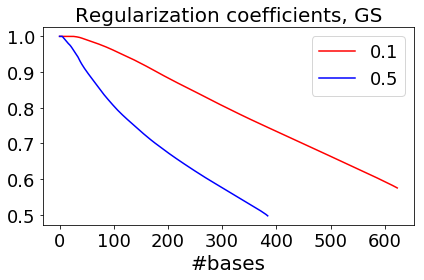

501 288


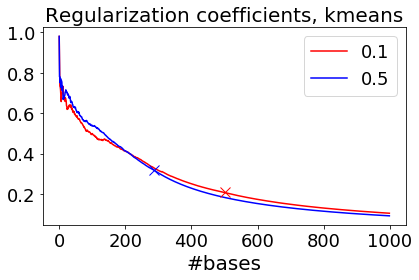

501 288


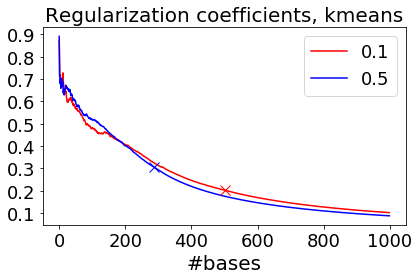

501 288


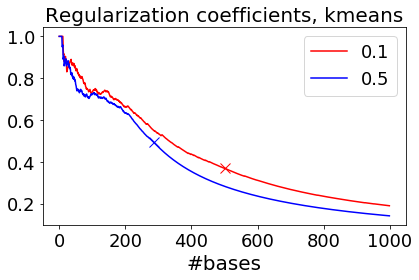

501 288


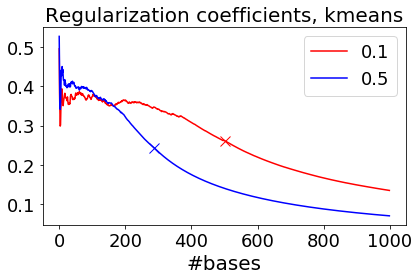

-1 -1


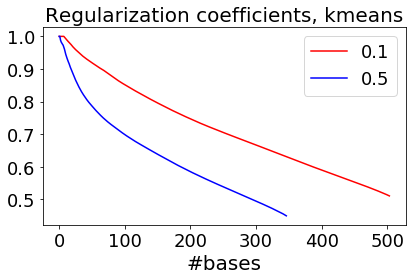

In [35]:
dl_400000_cNet_01 = load_data('glove300d_l_0.1_DL_top400000.emb.gz_f_conceptnet56_top50000')
dl_400000_cNet_05 = load_data('glove300d_l_0.5_DL_top400000.emb.gz_f_conceptnet56_top50000')
gs_400000_cNet_01 = load_data('glove300d_l_0.1_GS_top400000.emb.gz_f_conceptnet56_top50000')
gs_400000_cNet_05 = load_data('glove300d_l_0.5_GS_top400000.emb.gz_f_conceptnet56_top50000')
kmeans_400000_cNet_01 = load_data('glove300d_l_0.1_kmeans_top400000.emb.gz_f_conceptnet56_top50000')
kmeans_400000_cNet_05 = load_data('glove300d_l_0.5_kmeans_top400000.emb.gz_f_conceptnet56_top50000')
# kmeans_400000_cNet_01 = load_data('glove300d_l_0.1_kmeans_top400000.emb.gz_f_conceptnet56_top50000')
compare_reg_coeffs(dl_400000_cNet_01, dl_400000_cNet_05, 'DL')
compare_reg_coeffs(gs_400000_cNet_01, gs_400000_cNet_05, 'GS')
compare_reg_coeffs(kmeans_400000_cNet_01, kmeans_400000_cNet_05, 'kmeans')

# F-score

In [39]:
dl_400000_cNet = load_data('glove300d_l_0.5_DL_top400000.emb.gz_f_conceptnet56_top50000')
gs_400000_cNet = load_data('glove300d_l_0.5_GS_top400000.emb.gz_f_conceptnet56_top50000')
kmeans_400000_cNet = load_data('glove300d_l_0.5_kmeans_top400000.emb.gz_f_conceptnet56_top50000')
dense = load_data('glove.6B.400k.300d.txt_f_conceptnet56_top50000', True)

In [43]:
def fscore(metric1=dl_400000_cNet.map, metric2=dl_400000_cNet.tsa_base):
    precision = np.mean(metric1)
    recall = np.mean(metric2)
    fscore = 2*precision*recall/(precision+recall)
    return fscore

In [47]:
print('DL:',fscore(dl_400000_cNet.map, dl_400000_cNet.tsa_base))
print('GS:',fscore(gs_400000_cNet.map, gs_400000_cNet.tsa_base))
print('kmeans:',fscore(kmeans_400000_cNet.map, kmeans_400000_cNet.tsa_base))
print('dense:',fscore(dense.map, dense.tsa_base))

DL: 0.10544057369297818
GS: 0.1167301971947951
kmeans: 0.07158306814283474
dense: 0.06590106121810464


# ROC curve

In [95]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.title('ROC Curve', fontsize=15)
    plt.legend(fontsize=13)
    out_name = 'ROC_curve.pdf'
    plt.savefig(out_name)
    plt.show()

In [96]:
def get_recall(data):
    return np.mean(data.tsa_base)

In [97]:
# true positive rate = recall, false positive rate = fp/(fp+tn)
# order: dl, gs, kmeans, dense
fpr = [0.0, 0.16539197170583445, 0.1744726213493775, 0.23957202606644293, 0.7367252791828194, 1.0]
tpr = [0.0, get_recall(dl_400000_cNet), get_recall(gs_400000_cNet), get_recall(kmeans_400000_cNet), get_recall(dense), 1.0]

In [98]:
tpr

[0.0,
 0.1091247574198504,
 0.12561215053655533,
 0.06022503703828363,
 0.4033806763194394,
 1.0]

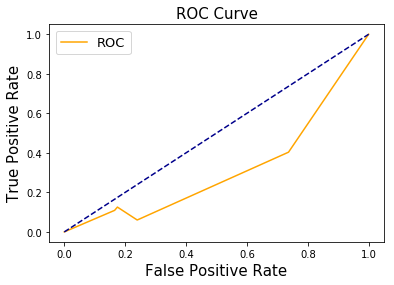

In [99]:
plot_roc_curve(fpr, tpr)